In [1]:
import pandas as pd
import sqlite3
import mpd
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

MPD_SRV = '192.168.1.111'
MPD_PORT = 6600
BEETS_DB = "./musiclibrary.blb"#careful of the extension, default is .blb but can be changed in conf
SHUFFLE = True
RECOMMENDATIONS = 20

conn = sqlite3.connect(BEETS_DB)

## Load the 'items' table

In [2]:
# load the desired columns from the table into a DF
df_items = pd.read_sql_query("select id, title, artist, length, year, album, genre, grouping, path from items;", conn)
# cast path type to str
df_items['path'] = df_items['path'].astype('str')

## Load the 'item_attributes' table

In [3]:
# load entire 'item_attributes' to a DF
df_attr = pd.read_sql_query("select id, entity_id, key, value from item_attributes;", conn)

# pivot columns to rows
pivot = df_attr.pivot(index='entity_id', columns='key', values='value')

# create column 'id' to merge
pivot['id'] = pivot.index

## Join the 2 tables on 'id'

In [4]:
# merge the two df on 'id' column
df_item_attr = pd.merge(df_items, pivot, on='id', how='inner')

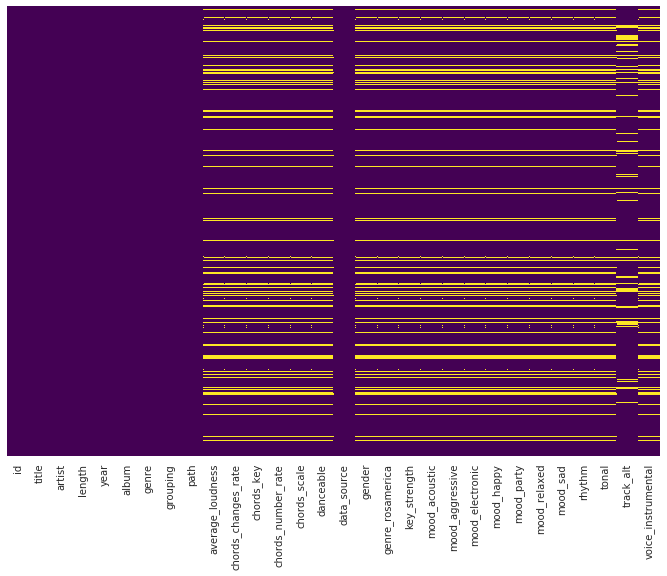

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df_item_attr.isnull(), yticklabels=False, cbar=False, cmap='viridis')

##df_item_attr.dropna(inplace=True) do this to drop rows with missing values (too many right now)

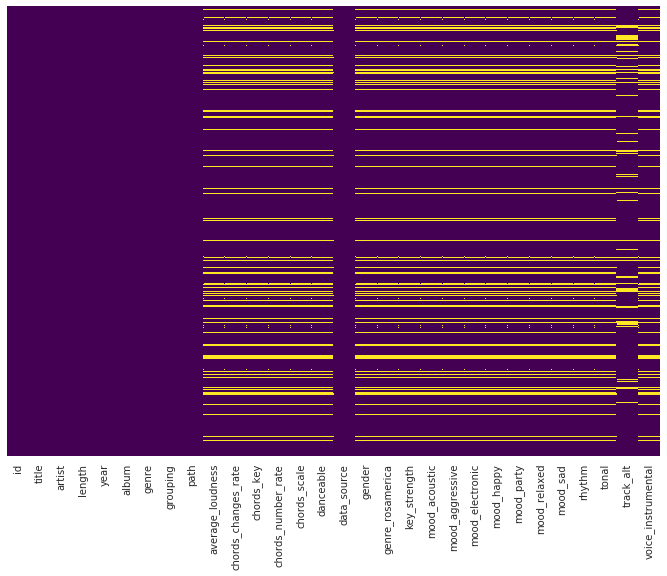

In [66]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df_item_attr.isnull(), yticklabels=False, cbar=False, cmap='viridis')

##df_item_attr.dropna(inplace=True) do this to drop rows with missing values (too many right now)

In [5]:
excludes = ['id','title','artist','album','length','year','data','soup','path','data_source']
keys = [str(key) for key in df_item_attr.keys().values if key not in excludes]

## Create the soup of keywords used for the similarity calculation

In [6]:
def create_soup(x):
    return ' '.join([str(x[key]) for key in keys])

df_item_attr['soup'] = df_item_attr.apply(create_soup, axis=1)

In [12]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_item_attr['soup'])

In [13]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [14]:
# Reset index of your main DataFrame and construct reverse mapping as before
df_items = df_items.reset_index()
indices = pd.Series(df_items.index, index=df_items['id'])

In [15]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(seed, recommendations, cosine_sim=cosine_sim2):

    # Get the index of the movie that matches the title
    idx = indices[seed]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the <length> most similar tracks
    sim_scores = sim_scores[1:recommendations+1]

    # Get the track indices
    track_indices = [i[0] for i in sim_scores]
    
    return track_indices

## Either select a seed song manually or make a random selection

In [62]:
#seed = 78
seed = random.choice(df_items['id'])

In [63]:
recommendation_indices = get_recommendations(seed, RECOMMENDATIONS, cosine_sim2)

seed_item = df_items[df_items['id']==seed]

print "Getting the top {} most similar tracks for song".format(RECOMMENDATIONS)
print "{} by {}\n".format((seed_item['title'].iloc[0]).encode('utf-8'),(seed_item['artist'].iloc[0]).encode('utf-8'))

if SHUFFLE:
    random.shuffle(recommendation_indices)
    
for c, index in enumerate(recommendation_indices):
    print "{}.\t{} - {}".format(c+1, (df_items['title'].iloc[index]).encode('utf-8'), (df_items['artist'].iloc[index]).encode('utf-8'))


Getting the top 20 most similar tracks for song
Soul Love by David Bowie

1.	Lady Stardust - David Bowie
2.	Peace Pipe - The Shadows
3.	Life on Mars? - David Bowie
4.	Life’s a Gas - T. Rex
5.	Avalon - Roxy Music
6.	The Bewlay Brothers - David Bowie
7.	You Know My Name (Look Up the Number) - The Beatles
8.	Love Is the Drug - Roxy Music
9.	Amanaz - Amanaz
10.	Overture / It’s a Boy - The Who
11.	Silver and Gold (Sun City) - Bono
12.	If God Will Send His Angels - U2
13.	I Can’t Hold Out - Eric Clapton
14.	We Are the Champions - Queen
15.	Cripple Creek Ferry - Neil Young
16.	You Got the Silver - The Rolling Stones
17.	Slim Slow Slider - Van Morrison
18.	Cosmic Dancer - T. Rex
19.	All Dead, All Dead - Queen
20.	Life on Mars? - David Bowie


In [64]:
client = mpd.MPDClient()

try:
    client.connect(MPD_SRV, MPD_PORT)
except socket.error:
    print "couldn't connect to mpd server."

'937'

In [65]:
client.clear()
for index in recommendation_indices:
    try:
        path = df_items['path'].iloc[index]
        path = path.replace('/media','USB')
        client.addid(path)
    except mpd.CommandError, cer:
        print cer
        print "failed to ad {}".format(path)
        pass
client.play()

In [ ]:
#import socket
#from mpd import ConnectionError

# try:
#     client.connect(host, port)
# except socket.error:
#     print "couldn't connect to mpd server."
#     raise
# except ConnectionError as coner:
#     print "ConnectionError: {}".format(coner)

# client.status()